In [11]:
import pandas as pd

df=pd.read_csv("aqar.csv")

pd.set_option("display.max_columns",None)
df.columns


Index(['id', 'title', 'url', 'price', 'meter_price', 'price_2_payments',
       'price_4_payments', 'price_12_payments', 'rnpl_monthly_price',
       'area_sqm', 'deed_area', 'num_bedrooms', 'num_bathrooms',
       'num_living_rooms', 'num_kitchens', 'num_rooms', 'floor_level',
       'furnished', 'duplex', 'ac', 'lift', 'maid_room', 'driver_room', 'pool',
       'basement', 'backyard', 'playground', 'car_entrance', 'stairs',
       'water_availability', 'electrical_availability',
       'drainage_availability', 'private_roof', 'two_entrances',
       'special_entrance', 'apartment_in_villa', 'street_width', 'direction',
       'city', 'district', 'address', 'latitude', 'longitude', 'category_id',
       'category_ga_listing_type', 'category_ga_property_category',
       'category_is_rent', 'category_name', 'category_en', 'category_plural',
       'category_uri', 'category_path', 'category_keywords',
       'category_description', 'category_index', 'sale_type', 'is_rental',
       'is_

- Use Y-data
- try multi layer preceptron(loss-funtion MSE, opt: adamw, Activation: Leaky ReLU)
- try a Layered ML model(Use three diffrent ml models, they output to the forth)


In [ ]:
df.hist(bins=50, figsize=(20,15))

In [ ]:

num_feature_cols=["area_sqm","num_bedrooms","num_rooms"]
cat_feature_cols=["district","city_grouped"]
bool_feature_cols=["lift"]

df : pd.DataFrame = df[(df['is_rental'] == False) & (df['is_daily_rental'] == False) & (df['sale_type'] != 'rent') & (df['sale_type'] !='daily')].copy()
pd.set_option('future.no_silent_downcasting', True)
# drop listings of land without buildings
df : pd.DataFrame = df[df['category_ga_property_category'] != 'land'].copy()
# drop listings of commercial buildings
df : pd.DataFrame = df[(df["category_ga_listing_type"]!= "office") & (df["category_ga_listing_type"]!="store") & (df["category_ga_listing_type"]!="warehouse") & (df["category_ga_listing_type"]!="lounge")].copy()

for bool_col in bool_feature_cols:
    df[bool_col] = df[bool_col].astype(int)

# combine rare cities into 'Other'
city_counts = df['city'].value_counts(normalize=True)
rare_cities = city_counts[city_counts < 0.02].index
df['city_grouped'] = df['city'].apply(lambda x: 'other' if x in rare_cities else x)

target_col=["price"]


df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].head(10)


,area_sqm,num_bedrooms,num_rooms,district,city_grouped,lift,price
0,116.0,4.0,4.0,حي النرجس,الرياض,0,1500000.0
1,700.0,7.0,7.0,حي الملقا,الرياض,1,13500000.0
3,215.0,6.0,6.0,حي دره المنسك,other,0,635000.0
4,169.0,5.0,5.0,حي ابها الجديده,other,0,510000.0
5,208.0,6.0,6.0,حي القريقر,other,0,540000.0
6,127.0,4.0,4.0,حي البوادي,جده,1,558000.0
7,736.0,2.0,2.0,حي المهديه,الرياض,1,717000.0
8,201.0,6.0,6.0,حي النهضه,other,0,550000.0
11,200.0,4.0,4.0,حي عكاظ,الرياض,0,695000.0
12,223.0,6.0,6.0,حي النهضه,other,0,530000.0


array([[<Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'num_bedrooms'}>],
       [<Axes: title={'center': 'num_rooms'}>,
        <Axes: title={'center': 'lift'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

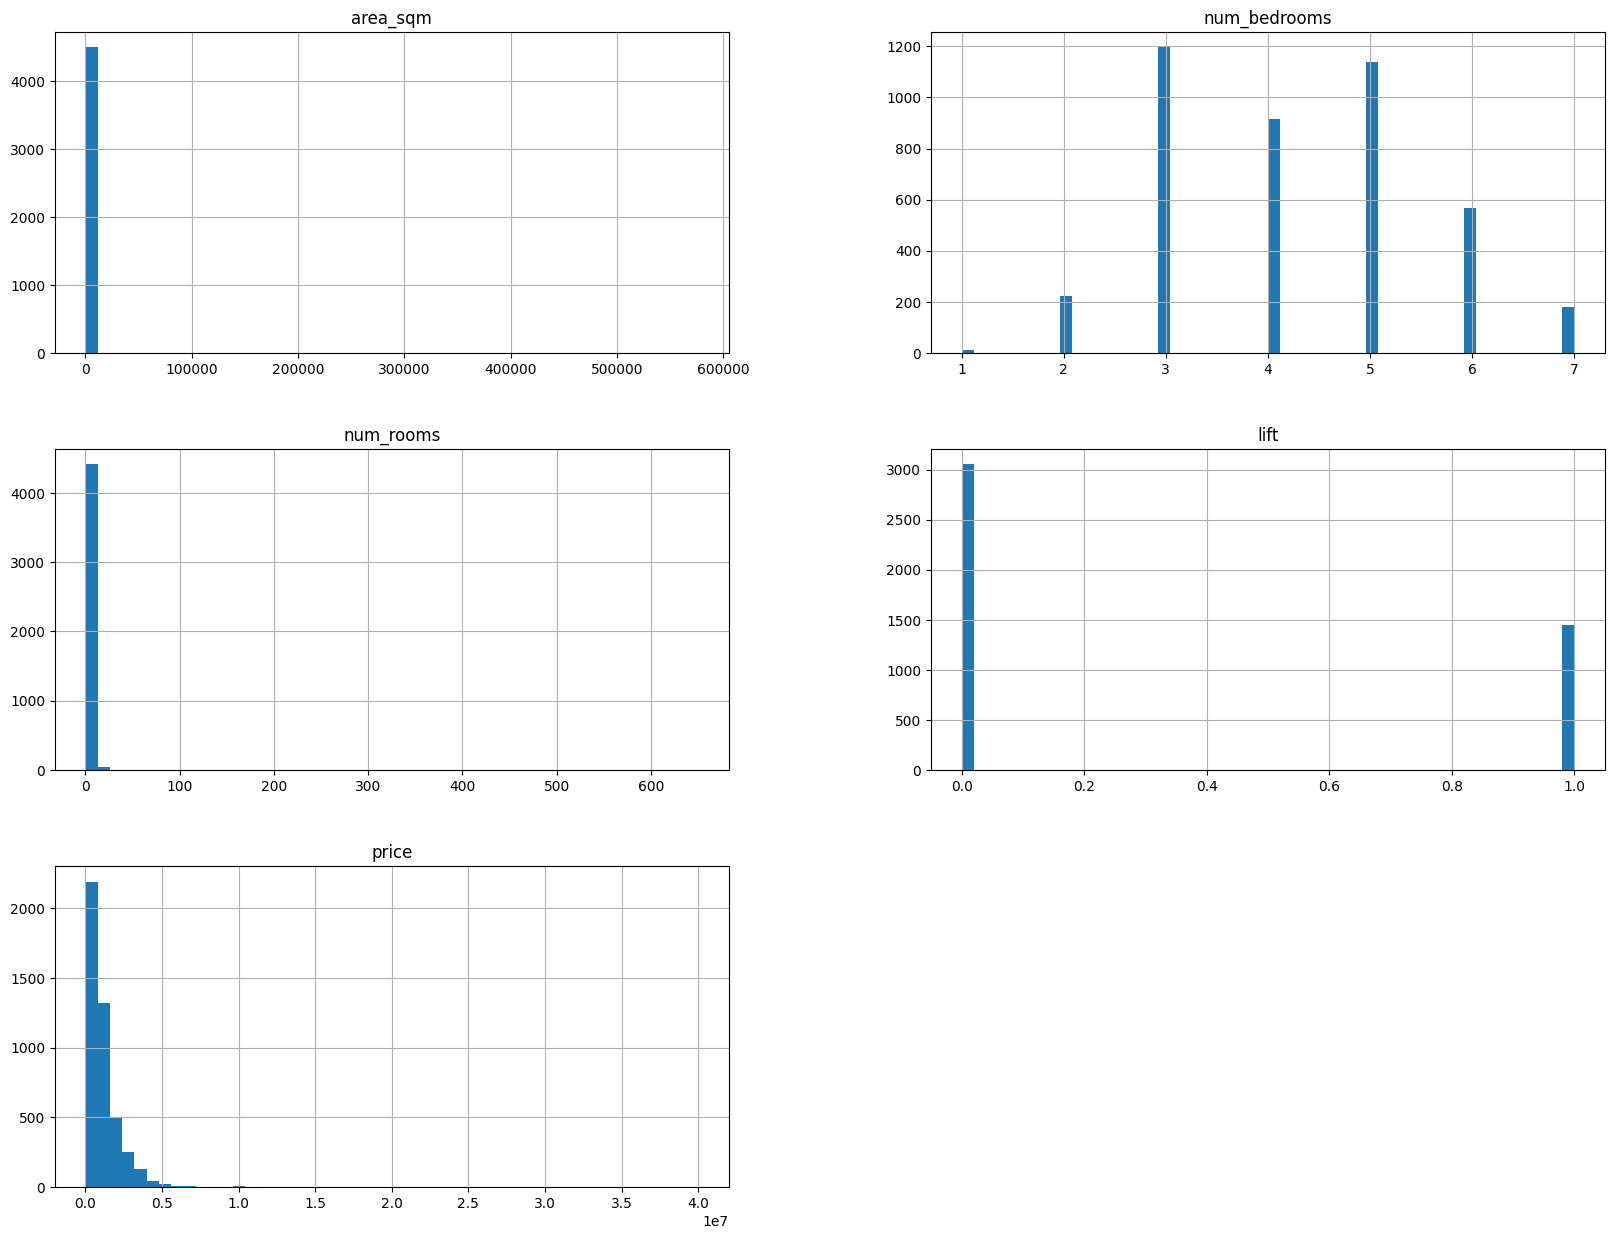

In [ ]:
df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].hist(bins=50, figsize=(20,15))


In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Aqar Data Profiling Report", explorative=True)
profile.to_file("raw_aqar_data_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:00<00:00, 142.53it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# 4502 is the number of rows 
# 1933 is the number of missing values in num_bathrooms
df["num_bedrooms"].isna().sum()
df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].isnull().sum()


In [ ]:
# Profile Data
profile = ProfileReport(df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].copy(), title="Aqar Dataset Profiling Report")
profile.to_file("aqar_data_profiling_report.html")


In [ ]:
# Model Training and Evaluation before preprocessing pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [ ]:

# Data Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, TargetEncoder, PolynomialFeatures

pipe1= ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False))
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
])

pipe2 = ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False))
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
])
pipe3 = ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False))
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
])

pipe4 = ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("target_enc", TargetEncoder())
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
])

pipe5 = ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("target_enc", TargetEncoder())
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
])


# Define features and target
X = df[num_feature_cols + cat_feature_cols + bool_feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
import numpy as np

from sklearn.model_selection import cross_validate, GridSearchCV
import numpy as np

# Define models with hyperparameter grids
model_configs = {
    "HistGB": {
        'model': HistGradientBoostingRegressor(random_state=42),
        'params': {
            'model__max_iter': [300, 500],
            'model__max_depth': [5, 8],
            'model__learning_rate': [0.03, 0.05]
        }
    },
    "XGBoost": {
        'model': XGBRegressor(
            random_state=42,
            objective='reg:squarederror',
            tree_method='hist'
        ),
        'params': {
            'model__n_estimators': [300],
            'model__max_depth': [5, 7],
            'model__learning_rate': [0.05]
        }
    },
    "RandomForest": {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [300],
            'model__max_depth': [20],
            'model__min_samples_leaf': [2, 5]
        }
    }
}

pipelines = {
    'pipe1_no_scaling': pipe1,
    'pipe2_with_scaling': pipe2,
    "pipe3_robust_scaling": pipe3,
    "pipe4_target_encoding": pipe4,
    "pipe5_robust_target_encoding": pipe5
}

# Store results
results = []
best_models = {}

for pipe_name, pipe in pipelines.items():
    pipelines[pipe_name] = pipe.set_output(transform="pandas")
    for model_name, config in model_configs.items():
        print(f"\nTraining {model_name} with {pipe_name}...")
        
        # Create pipeline
        full_pipeline = Pipeline([
            ("preprocessing", pipe),
            ("model", config['model'])
        ])
        
        # Tune hyperparameters if params exist
        if config['params']:
            grid_search = GridSearchCV(
                full_pipeline,
                config['params'],
                cv=5,
                scoring='r2',
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(X_train, y_train.values.ravel())
            best_pipeline = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            best_pipeline = full_pipeline
            best_params = {}
        
        # Cross-validation with best model
        cv_results = cross_validate(
            best_pipeline, 
            X_train, 
            y_train.values.ravel(),
            cv=5,
            scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            return_train_score=True
        )
        
        # Store results
        results.append({
            'Pipeline': pipe_name,
            'Model': model_name,
            'Train R2': cv_results['train_r2'].mean(),
            'Test R2': cv_results['test_r2'].mean(),
            'Test R2 Std': cv_results['test_r2'].std(),
            'Test RMSE': -cv_results['test_neg_root_mean_squared_error'].mean(),
            'Test MAE': -cv_results['test_neg_mean_absolute_error'].mean(),
            'Best Params': str(best_params)
        })
        
        # Store best model
        best_models[f"{pipe_name}_{model_name}"] = best_pipeline

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R2', ascending=False)

print("\n=== Model Comparison Results (with Hyperparameter Tuning) ===")
print(results_df.to_string(index=False))

# Find best combination
best = results_df.iloc[0]
print(f"\n=== Best Model ===")
print(f"Pipeline: {best['Pipeline']}")
print(f"Model: {best['Model']}")
print(f"Test R2: {best['Test R2']:.4f} (±{best['Test R2 Std']:.4f})")
print(f"Test MSE: {best['Test RMSE']:.2f}")
print(f"Test MAE: {best['Test MAE']:.2f}")
print(f"Best Params: {best['Best Params']}")

# Final evaluation on test set
best_model_key = f"{best['Pipeline']}_{best['Model']}"
final_model = best_models[best_model_key]
y_pred = final_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"\n=== Final Test Set Performance ===")
print(f"Test R2: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.2f}")

        
results_df


Training RandomForest with pipe1_no_scaling...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Training StackingRegressor with pipe1_no_scaling...

Training LinearRegression with pipe1_no_scaling...

Training SVR with pipe1_no_scaling...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Training KNN with pipe1_no_scaling...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Training XGBoost with pipe1_no_scaling...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Training RandomForest with pipe2_with_scaling...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Training StackingRegressor with pipe2_with_scaling...

Training LinearRegression with pipe2_with_scaling...

Training SVR with pipe2_with_scaling...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Training KNN with pipe2_with_scaling...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Training XGBoost with pipe2_with_scaling...
Fitting 5 fo

/home/azoz-laptop/Desktop/Git-Projects/W3/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/azoz-laptop/Desktop/Git-Projects/W3/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/azoz-laptop/Desktop/Git-Projects/W3/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/azoz-laptop/Desktop/Git-Projects/W3/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/azoz-laptop/Desktop/Git-Projects/W3/.venv/lib/python3.12/site-packages/sklearn/mod

KeyboardInterrupt: 

In [ ]:
results_df.to_csv("model_comparison_results.csv", index=False)
results_df.to_json("model_comparison_results.json", orient="records")



In [ ]:

# Create a profiling-only pipeline (imputation + scaling, but no OHE)
profiling_pipe = ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
], remainder='drop').set_output(transform="pandas")

# Transform for profiling
X_train_for_profiling = profiling_pipe.fit_transform(X_train)
X_train_for_profiling['price'] = y_train.values

# Generate profile
profile_preprocessed = ProfileReport(X_train_for_profiling, title="Aqar Preprocessed Data Profiling Report (No OHE)")
profile_preprocessed.to_file("aqar_preprocessed_data_profiling_report.html")
print("Preprocessed data profiling report saved!")
print(f"\nProfiled data shape: {X_train_for_profiling.shape}")
print("Categorical columns preserved for easier interpretation")

In [ ]:
# plot histograms of preprocessed features
X_train_for_profiling.hist(bins=50, figsize=(20,15))